#Экспорт датасета из roboflow

In [ ]:
# Установка библиотеки roboflow
!pip install roboflow

# Импорт и авторизация в Roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="FoGVG6irzBU8JzOqY72L")

# Загрузка проекта и версии
project = rf.workspace("orion-msydo").project("ship-detection-yr46o")
version = project.version(4)
dataset = version.download("yolov8-obb")

# Проверка, куда скачался датасет
print("\nДатасет скачан в:", dataset.location)

#Процентное соотношение train/valid/test

In [10]:
# Подсчет изображений
train_images = len(os.listdir('Ship-detection-4/train/images'))
valid_images = len(os.listdir('Ship-detection-4/valid/images'))
test_images = len(os.listdir('Ship-detection-4/test/images'))
total_images = train_images + valid_images + test_images

# Вывод результатов
print(f"Total: {total_images}")
print(f"Train: {train_images} ({train_images / total_images:.2%})")
print(f"Valid: {valid_images} ({valid_images / total_images:.2%})")
print(f"Test: {test_images} ({test_images / total_images:.2%})")

Total: 9667
Train: 9249 (95.68%)
Valid: 412 (4.26%)
Test: 6 (0.06%)


#Гистограмма классов

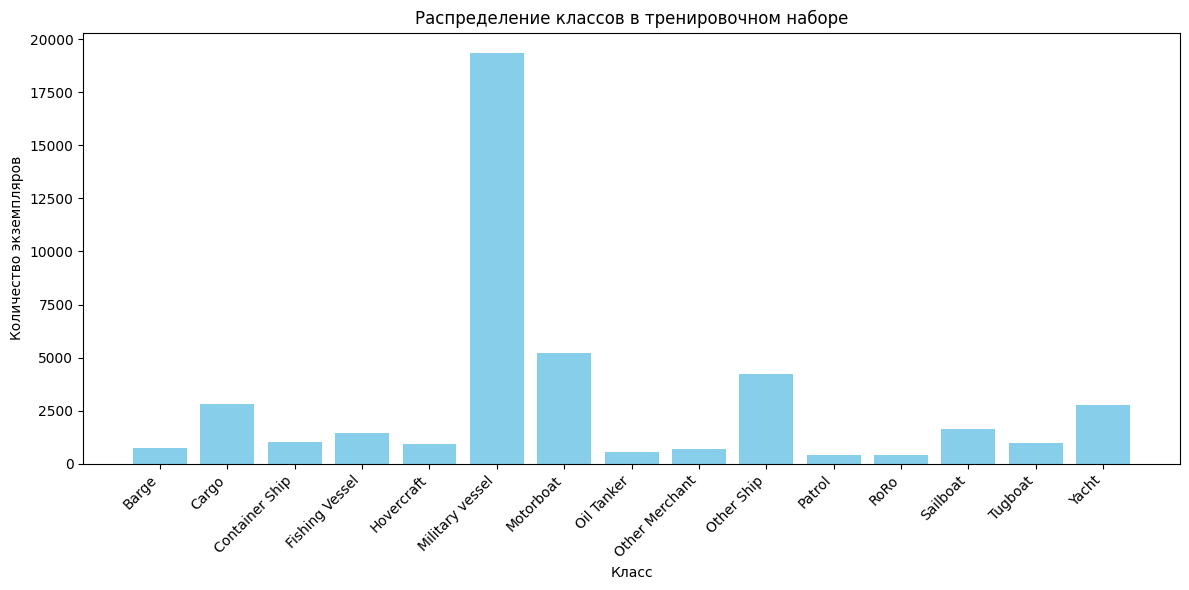

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Путь к аннотациям тренировочного набора
train_labels_path = 'Ship-detection-4/train/labels'

# Список классов (15 штук)
classes = [
    'Barge', 'Cargo', 'Container Ship', 'Fishing Vessel', 'Hovercraft',
    'Military Vessel', 'Motorboat', 'Oil Tanker', 'Other Merchant',
    'Other Ship', 'Patrol', 'RoRo', 'Sailboat', 'Tugboat', 'Yacht'
]

# Функция для чтения аннотаций из файла
def read_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    return [int(line.split()[0]) for line in lines]

# Подсчет экземпляров каждого класса
class_counts = {cls: 0 for cls in classes}
for label_file in os.listdir(train_labels_path):
    if label_file.endswith('.txt'):
        labels = read_labels(os.path.join(train_labels_path, label_file))
        for label in labels:
            class_counts[classes[label]] += 1

# Построение гистограммы
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Распределение классов в тренировочном наборе')
plt.xlabel('Класс')
plt.ylabel('Количество экземпляров')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Примеры изображений с аннотациями

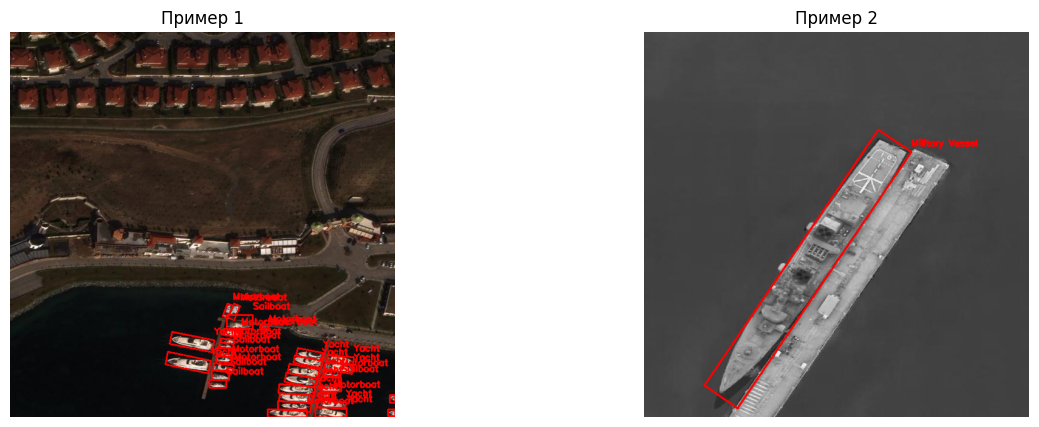

In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

def visualize_image_with_annotations(image_path, label_path, classes):
    # Загрузка изображения
    img = cv2.imread(image_path)
    if img is None:
        print(f"Не удалось загрузить изображение: {image_path}")
        return None

    # Получение размеров изображения
    h, w = img.shape[:2]

    # Чтение разметки
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        # Предполагаем, что координаты нормализованы (x1, y1, x2, y2, x3, y3, x4, y4)
        points = list(map(float, parts[1:]))

        # Преобразование в массив numpy и денормализация
        points = np.array(points).reshape(-1, 2)  # Формат: [[x1, y1], [x2, y2], ...]
        points[:, 0] *= w  # Денормализация x-координат
        points[:, 1] *= h  # Денормализация y-координат
        points = points.astype(int)  # Преобразование в целые числа

        # Отрисовка полигона (красным цветом)
        cv2.polylines(img, [points], isClosed=True, color=(0, 0, 255), thickness=2)

        # Добавление метки класса
        label_pos = (points[0, 0], points[0, 1] - 10)  # Чуть выше первой точки
        cv2.putText(img, classes[class_id], label_pos, cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 0, 255), 2)

    # Преобразование BGR в RGB для отображения
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

# Список классов
classes = ['Barge', 'Cargo', 'Container Ship', 'Fishing Vessel', 'Hovercraft',
           'Military Vessel', 'Motorboat', 'Oil Tanker', 'Other Merchant',
           'Other Ship', 'Patrol', 'RoRo', 'Sailboat', 'Tugboat', 'Yacht']

# Пути к директориям
images_dir = 'Ship-detection-4/train/images'
labels_dir = 'Ship-detection-4/train/labels'

# Получение списка всех изображений
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

# Случайный выбор двух изображений
selected_images = random.sample(image_files, 2)

# Визуализация
plt.figure(figsize=(15, 5))

for i, image_file in enumerate(selected_images):
    # Полный путь к изображению
    image_path = os.path.join(images_dir, image_file)
    # Предполагаем, что имя файла меток совпадает с именем изображения, но с расширением .txt
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    # Проверка существования файла меток
    if not os.path.exists(label_path):
        print(f"Файл меток не найден: {label_path}")
        continue

    # Визуализация изображения с аннотациями
    img_with_annotations = visualize_image_with_annotations(image_path, label_path, classes)
    if img_with_annotations is not None:
        plt.subplot(1, 2, i + 1)
        plt.imshow(img_with_annotations)
        plt.title(f'Пример {i + 1}')
        plt.axis('off')

plt.show()

#Зависимость между классами

In [18]:
from collections import defaultdict
import itertools

class_counts = defaultdict(int)
for label_file in os.listdir(train_labels_path):
    if label_file.endswith('.txt'):
        labels = read_labels(os.path.join(train_labels_path, label_file))
        for label in labels:
            class_counts[label] += 1

# Подсчет частот пар
pair_counts = defaultdict(int)
for label_file in os.listdir(train_labels_path):
    if label_file.endswith('.txt'):
        labels = read_labels(os.path.join(train_labels_path, label_file))
        unique_labels = set(labels)
        for pair in itertools.combinations(unique_labels, 2):
            pair_counts[tuple(sorted(pair))] += 1

# Нормализация частот пар
normalized_pair_counts = {}
for pair, count in pair_counts.items():
    cls1, cls2 = pair
    min_freq = min(class_counts[cls1], class_counts[cls2])
    normalized_pair_counts[pair] = count / min_freq if min_freq > 0 else 0

# Выбор топ-5 пар
top_5_pairs = sorted(normalized_pair_counts.items(), key=lambda x: x[1], reverse=True)[:5]

# Вывод результатов
print("Топ-5 пар классов по нормализованной частоте:")
for pair, norm_count in top_5_pairs:
    print(f"{classes[pair[0]]} и {classes[pair[1]]}: {norm_count:.2f}")

Топ-5 пар классов по нормализованной частоте:
Military Vessel и Patrol: 0.35
Hovercraft и Military Vessel: 0.34
Military Vessel и Other Ship: 0.29
Barge и Tugboat: 0.25
Military Vessel и Other Merchant: 0.23


#Анализ размеров изображений

In [12]:
from PIL import Image

# Функция для получения размеров изображений
def get_image_sizes(folder):
    sizes = []
    for img_file in os.listdir(folder):
        if img_file.endswith('.jpg') or img_file.endswith('.png'):
            img_path = os.path.join(folder, img_file)
            with Image.open(img_path) as img:
                sizes.append(img.size)
    return sizes

# Анализ размеров в тренировочном наборе
train_sizes = get_image_sizes('Ship-detection-4/train/images')
unique_sizes = set(train_sizes)
print(f"Уникальные размеры изображений: {unique_sizes}")
if len(unique_sizes) == 1:
    print("Все изображения имеют одинаковый размер, предобработка выполнена корректно.")
else:
    print("Есть изображения с разными размерами.")

Уникальные размеры изображений: {(640, 640)}
Все изображения имеют одинаковый размер, предобработка выполнена корректно.


#Анализ пропорций bounding boxes

In [19]:
# Функция для вычисления пропорций OBB
def get_bbox_aspect_ratio_with_angle(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    ratios = []
    class_ids = []
    angles = []
    for line in lines:
        parts = line.split()
        class_id = int(parts[0])
        points = list(map(float, parts[1:]))
        points = np.array(points).reshape(-1, 2)

        # Вычисление центроида
        centroid = np.mean(points, axis=0)

        # Центрирование точек
        centered_points = points - centroid

        # Вычисление ковариационной матрицы
        cov = np.cov(centered_points.T)

        # Нахождение собственных значений и векторов
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Главная ось (с наибольшим собственным значением)
        idx = np.argmax(eigenvalues)
        principal_axis = eigenvectors[:, idx]

        # Вычисление угла в градусах
        angle = np.arctan2(principal_axis[1], principal_axis[0]) * 180 / np.pi
        angles.append(angle)

        # Проекция точек на главные оси
        proj_x = np.dot(centered_points, principal_axis)
        proj_y = np.dot(centered_points, np.array([-principal_axis[1], principal_axis[0]]))

        # Вычисление ширины и высоты
        width = np.max(proj_x) - np.min(proj_x)
        height = np.max(proj_y) - np.min(proj_y)

        if height > 0:  # Избегаем деления на ноль
            ratios.append(width / height)
            class_ids.append(class_id)

    return class_ids, ratios, angles

# Сбор данных
aspect_ratios = {cls: [] for cls in classes}
angles_data = {cls: [] for cls in classes}
for label_file in os.listdir(train_labels_path):
    if label_file.endswith('.txt'):
        class_ids, ratios, angles = get_bbox_aspect_ratio_with_angle(os.path.join(train_labels_path, label_file))
        for cid, ratio, angle in zip(class_ids, ratios, angles):
            aspect_ratios[classes[cid]].append(ratio)
            angles_data[classes[cid]].append(angle)

# Средние пропорции для каждого класса
for cls in classes:
    if aspect_ratios[cls]:
        mean_ratio = np.mean(aspect_ratios[cls])
        print(f"{cls}: Средняя пропорция (ширина/высота) = {mean_ratio:.2f}")

Barge: Средняя пропорция (ширина/высота) = 3.39
Cargo: Средняя пропорция (ширина/высота) = 5.46
Container Ship: Средняя пропорция (ширина/высота) = 4.96
Fishing Vessel: Средняя пропорция (ширина/высота) = 3.23
Hovercraft: Средняя пропорция (ширина/высота) = 2.74
Military Vessel: Средняя пропорция (ширина/высота) = 7.36
Motorboat: Средняя пропорция (ширина/высота) = 2.49
Oil Tanker: Средняя пропорция (ширина/высота) = 5.52
Other Merchant: Средняя пропорция (ширина/высота) = 4.00
Other Ship: Средняя пропорция (ширина/высота) = 4.28
Patrol: Средняя пропорция (ширина/высота) = 5.12
RoRo: Средняя пропорция (ширина/высота) = 4.83
Sailboat: Средняя пропорция (ширина/высота) = 2.54
Tugboat: Средняя пропорция (ширина/высота) = 3.00
Yacht: Средняя пропорция (ширина/высота) = 3.65
